In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
DATA_ROOT = "/scratch/robertblackwell/label3/train/"
DATA_ROOT_TEST = "/scratch/robertblackwell/label3/test/"

In [3]:
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((256,256))
    ])

In [4]:
dataset = torchvision.datasets.ImageFolder(DATA_ROOT, transforms)
dataset_test = torchvision.datasets.ImageFolder(DATA_ROOT_TEST, transforms)

In [5]:
class_names = dataset.classes
class_names, len(class_names)

(['annelida_polychaeta',
  'appendicularia',
  'bivalvia-larvae',
  'byrozoa-larvae',
  'chaetognatha',
  'cirripedia_barnacle-nauplii',
  'cladocera',
  'cladocera_evadne-spp',
  'cnidaria',
  'copepod_calanoida',
  'copepod_calanoida_acartia-spp',
  'copepod_calanoida_calanus-spp',
  'copepod_calanoida_candacia-spp',
  'copepod_calanoida_centropages-spp',
  'copepod_calanoida_para-pseudocalanus-spp',
  'copepod_calanoida_temora-spp',
  'copepod_cyclopoida',
  'copepod_cyclopoida_corycaeus-spp',
  'copepod_cyclopoida_oithona-spp',
  'copepod_cyclopoida_oncaea-spp',
  'copepod_harpacticoida',
  'copepod_nauplii',
  'copepod_unknown',
  'decapoda-larvae_brachyura',
  'detritus',
  'echniodermata-larvae',
  'euphausiid',
  'euphausiid_nauplii',
  'fish-eggs',
  'gastropoda-larva',
  'mysideacea',
  'nt-bubbles',
  'nt-phyto_ceratium-spp',
  'nt-phyto_rhizosolenia-spp',
  'nt_phyto_chains',
  'ostracoda',
  'radiolaria',
  'tintinnida',
  'tunicata_doliolida'],
 39)

In [7]:
dataset_sizes = {'train': 50000, 'val': 1309, 'test': 5682}
train_set, val_set = torch.utils.data.random_split(dataset, [dataset_sizes['train'], dataset_sizes['val']])

dataloaders = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=4),
}


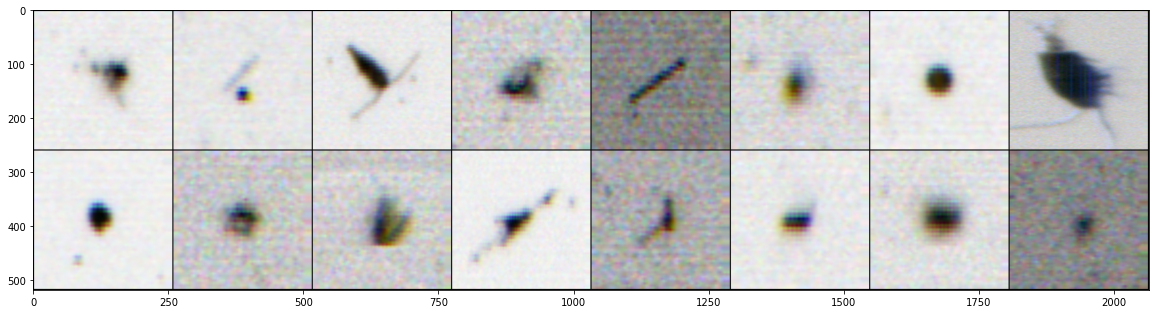

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(20, 20))
imshow(out, title=[dataset.classes[x] for x in classes])

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}/{}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = torchvision.models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = torch.nn.Linear(num_ftrs, 39)

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6089 Acc: 0.8234
val Loss: 0.4039 Acc: 0.8755

Epoch 1/24
----------
train Loss: 0.3635 Acc: 0.8838
val Loss: 0.3265 Acc: 0.8999

Epoch 2/24
----------
train Loss: 0.2800 Acc: 0.9076
val Loss: 0.3124 Acc: 0.8984

Epoch 3/24
----------
train Loss: 0.2201 Acc: 0.9259
val Loss: 0.2913 Acc: 0.9015

Epoch 4/24
----------
train Loss: 0.1748 Acc: 0.9399
val Loss: 0.4269 Acc: 0.8709

Epoch 5/24
----------
train Loss: 0.1321 Acc: 0.9552
val Loss: 0.3234 Acc: 0.8984

Epoch 6/24
----------
train Loss: 0.1002 Acc: 0.9670
val Loss: 0.3329 Acc: 0.9053

Epoch 7/24
----------
train Loss: 0.0377 Acc: 0.9903
val Loss: 0.2980 Acc: 0.9190

Epoch 8/24
----------
train Loss: 0.0219 Acc: 0.9961
val Loss: 0.3082 Acc: 0.9206

Epoch 9/24
----------
train Loss: 0.0168 Acc: 0.9976
val Loss: 0.3341 Acc: 0.9144

Epoch 10/24
----------
train Loss: 0.0128 Acc: 0.9986
val Loss: 0.3262 Acc: 0.9228

Epoch 11/24
----------
train Loss: 0.0109 Acc: 0.9989
val Loss: 0.3180 Acc: 0.9221

Ep

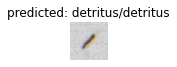

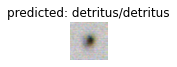

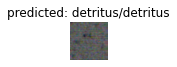

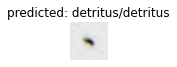

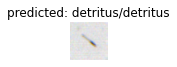

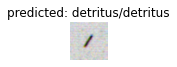

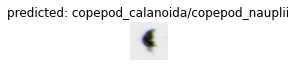

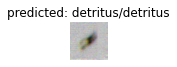

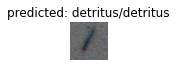

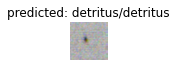

In [14]:
visualize_model(model_ft,10)

In [15]:
def evaluate(model,dataloader,dataset_size):
    since = time.time()
    
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_size
    test_acc = running_corrects.double() / dataset_size

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(
         test_loss, test_acc))


In [16]:
evaluate(model_ft, dataloaders['test'], dataset_sizes['test'])


Training complete in 0m 9s
Test Loss: 0.3507 Acc: 0.9155


In [17]:
nb_classes = 39

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.double())

tensor([[  6.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   6.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   3.,  ...,   0.,   0.,   0.],
        ...,
        [  1.,   0.,   0.,  ..., 179.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   2.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,  28.]], dtype=torch.float64)


In [18]:
torch.set_printoptions(sci_mode=False)
print(confusion_matrix.tolist())

[[6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.

In [19]:
import seaborn as sn
import pandas as pd

<AxesSubplot:>

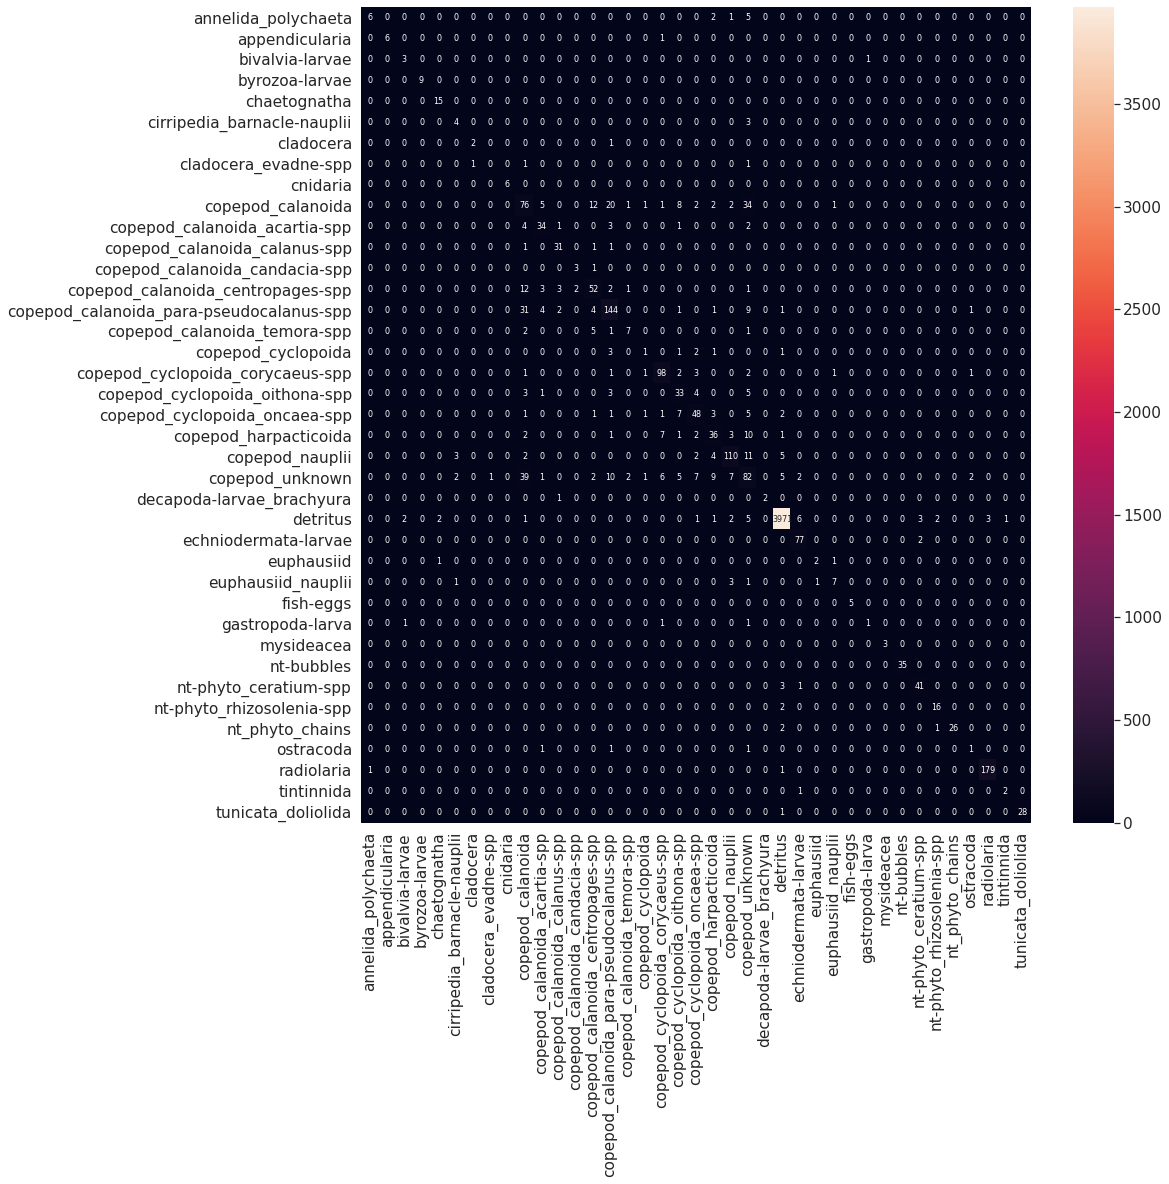

In [20]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype(np.int32), index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (15,15))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8},fmt='g') # font size



In [23]:
torch.save(model_ft.state_dict(), "/scratch/models/torch_resnet50_label3_rawdata.pth")

In [24]:
! pwd

/home/robert.blackwell/git/plankton-dsg-challenge/notebooks/python/dsg2021


In [27]:
def evaluate(confusion_matrix, classes):
    true_pos = np.diag(confusion_matrix)
    false_pos = np.sum(confusion_matrix, axis=0) - true_pos
    false_neg = np.sum(confusion_matrix, axis=1) - true_pos

    accuracy = sum(true_pos) / np.sum(confusion_matrix)
    precision = (true_pos / (true_pos + false_pos))
    recall = (true_pos / (true_pos + false_neg))
    f1 = 2*precision*recall / (precision + recall)
    
    print(precision)
    print(recall)

    precision = np.mean(precision)
    recall = np.mean(recall)

    f1 = np.mean(f1)
    return precision, recall, accuracy, f1

In [28]:
evaluate(confusion_matrix.numpy(),39)

[0.85714287 1.         0.5        1.         0.8333333  0.4
 0.6666667  0.         1.         0.4318182  0.6938776  0.81578946
 0.6        0.6666667  0.75       0.6363636  0.2        0.8521739
 0.55932206 0.6760563  0.6101695  0.859375   0.45810056 1.
 0.9939925  0.88505745 0.6666667  0.7        1.         0.5
 1.         1.         0.8913044  0.84210527 1.         0.2
 0.98351645 0.6666667  1.        ]
[0.42857143 0.85714287 0.75       1.         1.         0.5714286
 0.6666667  0.         1.         0.46060607 0.75555557 0.9117647
 0.75       0.68421054 0.72727275 0.4375     0.11111111 0.8909091
 0.67346936 0.6857143  0.5714286  0.8029197  0.44808742 0.6666667
 0.99275    0.9746835  0.5        0.53846157 1.         0.25
 1.         1.         0.9111111  0.8888889  0.8965517  0.25
 0.98895025 0.6666667  0.9655172 ]


<ipython-input-27-e162b4864744>:9: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2*precision*recall / (precision + recall)


(0.7281068, 0.7096053, 0.9155227032734953, nan)